<a href="https://www.kaggle.com/code/omaradel99/rock-paper-scissors-cnn-accuracy-99?scriptVersionId=265139719" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🪨📄✂️ Rock-Paper-Scissors Image Classification

## Introduction
The **Rock-Paper-Scissors** dataset is a simple yet effective benchmark for learning and practicing **image classification** using deep learning.  
It contains images of three distinct hand gestures representing the classic game:  
- **Rock (🪨)**  
- **Paper (📄)**  
- **Scissors (✂️)**  

This project aims to build a **Convolutional Neural Network (CNN)** model that can automatically classify images into one of the three categories.  
By doing so, we can practice essential steps in a computer vision workflow, including:  
- Image preprocessing and resizing  
- Data augmentation to improve generalization  
- Designing and training a CNN from scratch or using **transfer learning**  
- Evaluating model performance on unseen data  

Although the dataset is relatively small, it provides an excellent playground for experimenting with different architectures and techniques in deep learning.  
The skills learned here can be extended to more complex image recognition tasks in the real world.

---

# Libraries Used

In [37]:
import os
import glob as gb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learin
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Import OPEN_CV
import cv2

# Import tensorflow
import tensorflow as tf

# Using Keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization, MaxPooling2D, Input
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

#Model Interface
import gradio as gr

# 1. Data Loading & Exploration

In [20]:
data_path = '/kaggle/input/rockpaperscissors'
paper_path = '/kaggle/input/rockpaperscissors/paper'
rock_path = '/kaggle/input/rockpaperscissors/rock'
scissors_path = '/kaggle/input/rockpaperscissors/scissors'

In [21]:
print(os.listdir(data_path))

['paper', 'rock', 'rps-cv-images', 'README_rpc-cv-images.txt', 'scissors']


**Quick check on the dataset:**

In [22]:
for folder in ['paper', 'rock', 'scissors']:

    images = gb.glob(os.path.join(data_path, folder, '*.png'))
    print(f'Data, found {len(images)} in {folder} floder')

Data, found 712 in paper floder
Data, found 726 in rock floder
Data, found 750 in scissors floder


# 2. Data Preprocessing

## Data Augmentation

Image augmentation increases dataset diversity by applying transformations (zoom, shifts, flips, etc.) to training images.
This helps the model generalize better and avoid overfitting.

In [23]:
data_augmen = ImageDataGenerator(

    rescale = 1.0/255,            # Normalize pixel values from [0,255] → [0,1]
    zoom_range = 0.2,             # Random zoom to simulate different scales
    width_shift_range = 0.2,      # Random horizontal shifts
    height_shift_range = 0.2,     # Random vertical shifts
    rotation_range = 30,
    shear_range = 2, 
    fill_mode = 'nearest',        # If the images are shifted and gaps appear, the gaps are filled with the nearest pixels.
    validation_split = 0.2        # Split dataset: 80% train, 20% validation
)

train_generator = data_augmen.flow_from_directory(

    data_path,
    target_size = (150, 150),                  # Resize all images to 150x150
    batch_size = 32,                           # Number of images per batch
    classes = ['paper', 'rock', 'scissors'],   # We define classes only
    class_mode = 'categorical',                # Multi-class classification to be One-Hot encoding
    subset="training"                          # Use training subset
    
)

#  Validation data generator (uses 20% of data, same preprocessing)
val_generator = data_augmen.flow_from_directory(
    
    data_path,
    target_size = (150, 150),
    batch_size = 32,
    classes = ['paper', 'rock', 'scissors'],
    class_mode = "categorical",
    subset = "validation"                      # Use validation subset
    
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


In [24]:
print(train_generator.class_indices)
print(val_generator.class_indices)

{'paper': 0, 'rock': 1, 'scissors': 2}
{'paper': 0, 'rock': 1, 'scissors': 2}


# 3. Build The Model


### Sequential Method

In [25]:
cnn_model = Sequential([

    Input(shape=(150, 150, 3)),
    
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    # Dropout(0.3),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    # Dropout(0.3),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    # Dropout(0.5),
    MaxPooling2D(pool_size=(2, 2)), 

    Flatten(),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(), 
    Dropout(0.5),

    Dense(3, activation='softmax') 
    
])

cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,169,731 (73.13 MB)

 Trainable params: 19,167,747 (73.12 MB)

 Non-trainable params: 1,984 (7.75 KB)

### Early Stoping

In [26]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### Reduce Learning Rate on Plateau

In [27]:
exp_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,      # Starting value
    decay_steps=100,                  # Every few steps (batch) decay occurs
    decay_rate=0.96,                  # Decrease rate
    staircase=False                   # True = Decreases suddenly (step) / False = Decreases gradually
)

In [28]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

### Model Compile

In [29]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Training & Evaluation

### Trian The Model

In [30]:
traning_model = cnn_model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[early_stop, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 349ms/step - accuracy: 0.5283 - loss: 1.4483 - val_accuracy: 0.3318 - val_loss: 3.4425 - learning_rate: 0.0010
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step - accuracy: 0.8148 - loss: 0.5588 - val_accuracy: 0.3318 - val_loss: 5.4941 - learning_rate: 0.0010
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 282ms/step - accuracy: 0.8858 - loss: 0.3364 - val_accuracy: 0.3318 - val_loss: 5.0954 - learning_rate: 0.0010
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - accuracy: 0.9142 - loss: 0.2564 - val_accuracy: 0.3318 - val_loss: 6.0447 - learning_rate: 0.0010
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step - accuracy: 0.9565 - loss: 0.1418 - val_accuracy: 0.3318 - val_loss: 5.9622 - learning_rate: 0.0010
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step - accuracy: 0.9517 - loss: 0.1667 - val_accuracy: 0.3318 - val_loss: 5.7386 - learning_rate: 0.0010
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step - accuracy: 0.9499 - loss: 0.

### Model Evaluate

In [31]:
loss_train, accuracy_train = cnn_model.evaluate(train_generator)

loss_val, accuracy_val = cnn_model.evaluate(val_generator)

55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - accuracy: 0.9998 - loss: 0.0027
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.9995 - loss: 0.0065


In [32]:
print(f"Train Loss: {loss_train}")
print(f"Train Accuracy: {accuracy_train}")

print(f"Validation Loss: {loss_val}")
print(f"Validation Accuracy: {accuracy_val}")

Train Loss: 0.003216415410861373
Train Accuracy: 0.9994288682937622
Validation Loss: 0.01252561155706644
Validation Accuracy: 0.9977116584777832


# 5. Performance Analysis

In [33]:
training_loss = traning_model.history['loss']
training_accuracy = traning_model.history['accuracy']

validation_loss = traning_model.history['val_loss']
validation_accuracy = traning_model.history['val_accuracy']

# learning_rate = traning_model.history['lr']

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

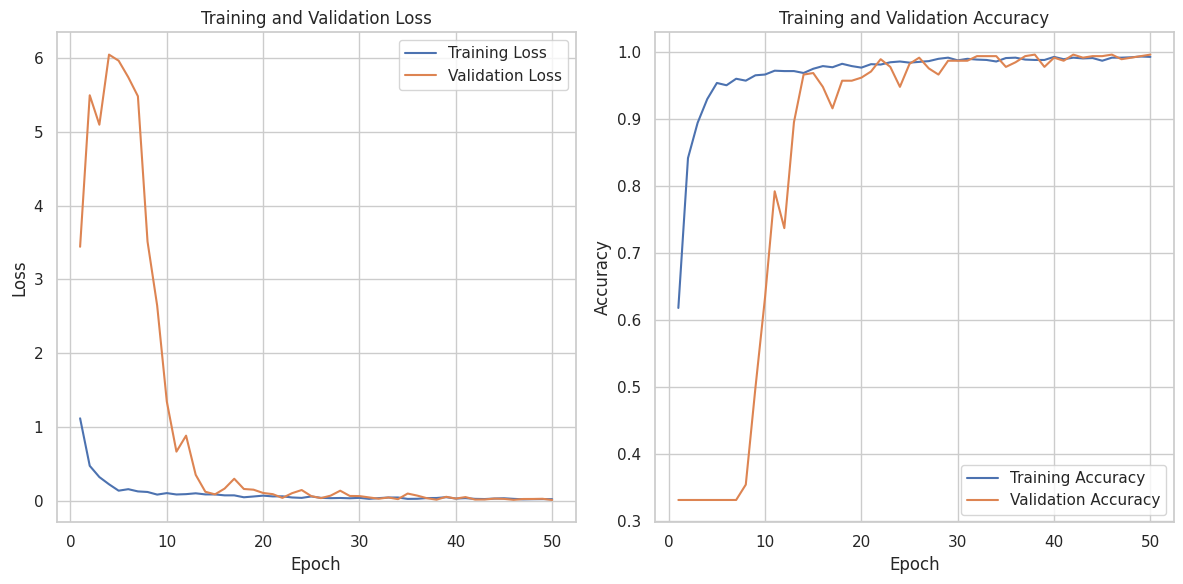

In [34]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, len(training_loss)+1), y=training_loss, label='Training Loss')
sns.lineplot(x=range(1, len(validation_loss)+1), y=validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, len(training_accuracy)+1), y=training_accuracy, label='Training Accuracy')
sns.lineplot(x=range(1, len(validation_accuracy)+1), y=validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Save The model

In [36]:
cnn_model.save("rps_cnn_model.h5")

In [ ]:
model = tf.keras.models.load_model("rps_cnn_model.h5")

In [38]:
class_labels = ['paper', 'rock', 'scissors']


In [39]:
def predict_rps(img):
    img = img.resize((150, 150))   # نفس حجم التدريب
    img = image.img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    
    pred = cnn_model.predict(img)
    class_idx = np.argmax(pred, axis=1)[0]
    return {class_labels[i]: float(pred[0][i]) for i in range(len(class_labels))}

In [40]:
demo = gr.Interface(
    fn=predict_rps,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="Rock Paper Scissors Classifier",
    description="Upload an image of Rock, Paper, or Scissors and the model will predict it."
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://00081ca5177fe0b132.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
